# Part I. Preparation

First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to download the CIFAR-10 dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [1]:
import torch
print(f'Your Pytorch version is {torch.__version__}')
assert '.'.join(torch.__version__.split('.')[:2]) in ['1.4','1.5','1.6']
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import numpy as np

Your Pytorch version is 1.6.0


In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment.

## Colab Users

If you are using Colab, you need to manually switch to a GPU device. You can do this by clicking `Runtime -> Change runtime type` and selecting `GPU` under `Hardware Accelerator`. Note that you have to rerun the cells from the top since the kernel gets restarted upon switching runtimes.

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

In [4]:
import torch.nn.functional as F  # useful stateless functions

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

# test_flatten()
# class Flatten(nn.Module):
#     def forward(self, x):
#         return flatten(x)

### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [5]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, CNN_net_width, CNN_out_width, dropout, hidden_1, num_classes, CNN_depth):
        super().__init__()
        
        self.CNN_depth = CNN_depth
        
        self.conv1 = nn.Conv2d(in_channel, CNN_net_width, 5, padding=0) # H*W = 28*28
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(CNN_net_width, CNN_net_width, 3, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(CNN_net_width, CNN_out_width, 3, padding=1)
        nn.init.kaiming_normal_(self.conv3.weight)
        
        self.batchNorm = nn.BatchNorm2d(CNN_net_width)
        self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=dropout)
        self.relu = nn.ReLU(inplace=True)
        
        self.fc1 = nn.Linear(CNN_out_width*14*14, hidden_1)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_1, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        scores = None
        
        c_mid = {}
        c_mid[0] = self.maxpool2d(self.relu(self.conv1(x))) # H*W = 14*14
        
        
        for i in range(self.CNN_depth):
            c_mid[i+1] = self.relu(self.conv2(self.batchNorm(self.dropout(c_mid[i]))))
            
        c_out = self.relu(self.conv3(self.batchNorm(self.dropout(c_mid[self.CNN_depth]))))
        scores = self.fc2(self.relu(self.fc1(flatten(c_out))))

        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, CNN_net_width=32, CNN_out_width = 20, dropout=0.2, hidden_1 = 50, num_classes=10, CNN_depth = 2)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
            
test_ThreeLayerConvNet()

torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [6]:
def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
#         print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [7]:
def showAcc(loss_his, train_his, vali_his):
    plt.subplot(2, 1, 1)
    plt.plot(loss_his, 'o')
    plt.xlabel('iteration')
    plt.ylabel('loss')

    plt.subplot(2, 1, 2)
    plt.plot(train_his, '-o')
    plt.plot(vali_his, '-o')
    plt.legend(['train', 'val'], loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()
    
def train_part34(model, optimizer, epochs=1, reg = 0.01, verbose = True):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    loss_his, train_his, vali_his = [], [], []
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    start_flag = True
    iteration = 0
    epo_it = {}
    epo_W1 = {}
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            iteration += 1
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            reg_loss = 0
            for name,parameters in model.named_parameters():
                reg_loss += torch.norm(parameters)
            loss += reg * reg_loss

            loss_his.append(loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if start_flag:
                start_flag = False
                vali_acc = check_accuracy_part34(loader_val, model)
                train_acc = check_accuracy_part34(loader_train, model)
                train_his.append(train_acc)
                vali_his.append(vali_acc)
                if verbose: print(f'Begin training, vali_acc = {vali_acc}, train_acc = {train_acc}')
         
        W1 = model.conv1.weight.cpu().detach().numpy().transpose(0, 2, 3, 1)
        epo_it[e] = iteration
        epo_W1[e] = W1
        vali_acc = check_accuracy_part34(loader_val, model)
        train_acc = check_accuracy_part34(loader_train, model)
        train_his.append(train_acc)
        vali_his.append(vali_acc)
        if verbose: print(f'After epoch {e}, vali_acc = {vali_acc}, train_acc = {train_acc}')
    his = {}
    his['vali_his'] = vali_his
    his['train_his'] = train_his
    his['loss_his'] = loss_his
    return his, epo_it, epo_W1

### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [8]:
learning_rate = 1e-3
CNN_mid_width=64
CNN_out_width = 20
dropout=0.2
hidden_fc = 50
epochs=8
reg = 0.02
CNN_depth = 1

model = None
optimizer = None
################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model =  ThreeLayerConvNet(in_channel=3, CNN_net_width=CNN_mid_width, CNN_out_width = CNN_out_width, 
                           dropout=dropout, hidden_1 = hidden_fc, num_classes=10, CNN_depth = CNN_depth)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

his, epo_it, epo_W1 = train_part34(model, optimizer, epochs=epochs, reg = reg, verbose = True)
test_vali_acc = check_accuracy_part34(loader_test, model)
print(f'Final ACC = {test_vali_acc}')

Begin training, vali_acc = 0.087, train_acc = 0.095
After epoch 0, vali_acc = 0.522, train_acc = 0.5172857142857142
After epoch 1, vali_acc = 0.628, train_acc = 0.6128163265306122
After epoch 2, vali_acc = 0.615, train_acc = 0.6265510204081632
After epoch 3, vali_acc = 0.617, train_acc = 0.6327959183673469
After epoch 4, vali_acc = 0.615, train_acc = 0.6376734693877552
After epoch 5, vali_acc = 0.638, train_acc = 0.6449183673469387
After epoch 6, vali_acc = 0.639, train_acc = 0.6408775510204081
After epoch 7, vali_acc = 0.611, train_acc = 0.6350204081632653
Final ACC = 0.6102


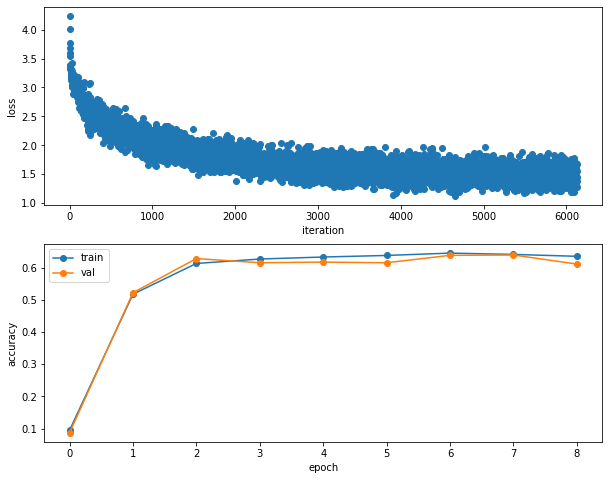

In [9]:
vali_his = his['vali_his'] 
train_his = his['train_his'] 
loss_his = his['loss_his'] 
showAcc(loss_his, train_his, vali_his)

In [10]:
# model.conv1.weight.shape
# for name,parameters in model.named_parameters():
#     print(name,':',parameters.size())

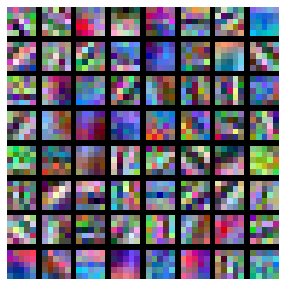

In [20]:
from cs231n.vis_utils import visualize_grid

W1 = epo_W1[7]

grid = visualize_grid(W1)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [ ]:
best_model = model
check_accuracy_part34(loader_test, best_model)

## 训练并存储数据

In [31]:
import pickle
import os.path

def savedb(obj,filename):
    with open(filename,'wb') as file:
        pickle.dump(obj,file)
    
def loaddb(filename):
    with open(filename,'rb') as file:
        obj = pickle.load(file)
        return obj
    
# his, epo_it, epo_W1
    
def pickle_exist(CNN_mid_width, CNN_d, drop, reg, lr, CNN_out_width, h_fc, epoch):
    filename = f'pickle/{CNN_mid_width}-{CNN_d}-{drop}-{reg}-{lr}-{CNN_out_width}-{h_fc}-{epoch}.pickle'
    if os.path.isfile(filename):
        return True
    return False

def save_pickle(CNN_mid_width, CNN_d, drop, reg, lr, CNN_out_width, h_fc, epoch, val_acc, his, epo_it, epo_W1, dtype = np.half):
#     W1 = dtype(W1)
    for key in epo_W1.keys():
        epo_W1[key] = dtype(epo_W1[key])
    for key in his.keys():
        his[key] = dtype(his[key])
    obj = (CNN_mid_width, CNN_d, drop, reg, lr, CNN_out_width, h_fc, epoch, val_acc, his, epo_it, epo_W1)
    filename = f'pickle/{CNN_mid_width}-{CNN_d}-{drop}-{reg}-{lr}-{CNN_out_width}-{h_fc}-{epoch}.pickle'
    savedb(obj,filename)

In [40]:
learning_rate = 2e-3
CNN_mid_width=[32, 64, 128]
# CNN_mid_width=[32]
CNN_out_width = 20
dropout = [0, 0.2, 0.5]
# dropout = [0.2]
hidden_fc = 50
epochs=8
regularization = [0.03, 0.02]
CNN_depth = [0, 2, 4, 6]
# CNN_depth = [0]

overall = len(CNN_mid_width) * len(dropout) * len(regularization) * len(CNN_depth)


def testParam(CNN_m, CNN_d, drop, reg):
    model =  ThreeLayerConvNet(in_channel=3, CNN_net_width=CNN_m, CNN_out_width = CNN_out_width, 
                           dropout=drop, hidden_1 = hidden_fc, num_classes=10, CNN_depth = CNN_d)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    his, epo_it, epo_W1 = train_part34(model, optimizer, epochs=epochs, reg = reg, verbose = False)
    test_vali_acc = check_accuracy_part34(loader_test, model)
    print(f'CNN_m: {CNN_m}, CNN_d: {CNN_d}, drop: {drop}, reg:{reg}, val_acc: {test_vali_acc}')
    return test_vali_acc, his, epo_it, epo_W1

i = 0
current = 0
lr = learning_rate
h_fc = hidden_fc
for CNN_m in CNN_mid_width:
    for CNN_d in CNN_depth:
        for reg in regularization:
            for drop in dropout:
                current += 1
                if pickle_exist(CNN_m, CNN_d, drop, reg, lr, CNN_out_width, h_fc, epochs):
                    print('.',end='')
                    if i%100 == 99:
                        print()
                    i+=1
                    continue
                print(f'[{current}/{overall}]', end = '')
                val_acc, his, epo_it, epo_W1 = testParam(CNN_m, CNN_d, drop, reg)
                save_pickle(CNN_m, CNN_d, drop, reg, lr, CNN_out_width, h_fc, epochs, val_acc, his, epo_it, epo_W1, dtype = np.half)

..................[19/72]CNN_m: 32, CNN_d: 6, drop: 0, reg:0.03, val_acc: 0.5353
[20/72]CNN_m: 32, CNN_d: 6, drop: 0.2, reg:0.03, val_acc: 0.1
[21/72]CNN_m: 32, CNN_d: 6, drop: 0.5, reg:0.03, val_acc: 0.2868
[22/72]CNN_m: 32, CNN_d: 6, drop: 0, reg:0.02, val_acc: 0.5042
[23/72]CNN_m: 32, CNN_d: 6, drop: 0.2, reg:0.02, val_acc: 0.4545
[24/72]CNN_m: 32, CNN_d: 6, drop: 0.5, reg:0.02, val_acc: 0.3929
..................[43/72]CNN_m: 64, CNN_d: 6, drop: 0, reg:0.03, val_acc: 0.4116
[44/72]CNN_m: 64, CNN_d: 6, drop: 0.2, reg:0.03, val_acc: 0.3989
[45/72]CNN_m: 64, CNN_d: 6, drop: 0.5, reg:0.03, val_acc: 0.4158
[46/72]CNN_m: 64, CNN_d: 6, drop: 0, reg:0.02, val_acc: 0.5223
[47/72]CNN_m: 64, CNN_d: 6, drop: 0.2, reg:0.02, val_acc: 0.4404
[48/72]CNN_m: 64, CNN_d: 6, drop: 0.5, reg:0.02, val_acc: 0.3921
..................[67/72]CNN_m: 128, CNN_d: 6, drop: 0, reg:0.03, val_acc: 0.5581
[68/72]CNN_m: 128, CNN_d: 6, drop: 0.2, reg:0.03, val_acc: 0.4066
[69/72]CNN_m: 128, CNN_d: 6, drop: 0.5, reg:0.0